# Cluster Analysis Based on MCI Original

In [200]:
'''
Import key packages
'''
import umap
import pandas as pd
import numpy as np
import re
import seaborn as sns
import matplotlib.pyplot as plt
import scipy
from functools import reduce
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans

# debug mode (spits messages verbosely)
DEBUG = 0  # change it to 0 to switch it off

loc="../../../WES/Clinical Data/Raw/"
outdata="../../../WES/Clinical Data/Processed/"

config =dict(\
varsnormalise=['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','BDI_BDI Total'],\
nonnormvars=['cog1_Trails A Z score','Lm2_cut','ESS_norm','FOGQ_FOGQ 3','DDE_norm'],\
umap_neigbours=10,umap_comps=2,kmeans_try=10)

varsnormalise=config['varsnormalise']
nonnormvars=config['nonnormvars']


varsnormalise=['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
'udprs_tremor_ratio','cog1_NART','BDI_BDI Total']
nonnormvars=['cog1_Trails A Z score','Lm2_cut','ESS_norm','FOGQ_FOGQ 3','DDE_norm']

In [201]:
def z_score(col):
    x = (col - col.mean())/col.std(ddof=0)
    return  x

def takeonlyx_sd(df,x=5):

    for var in df.columns:
        if re.search('float|int',str(df[var].dtype)):
            maxvar=df[var].mean()+df[var].std()*5
            minvar=df[var].mean()-df[var].std()*5
            mask_rng=(df[var].between(minvar,maxvar))
            df[var][~mask_rng]=df[var][mask_rng].mean()
           # print(df[var].max())
           # print(df.shape)
    return df

def replacenullsmean(df,dropcols=['SYDID','Date of assessment','max_date']):
    usecols=[col for col in df.columns if col not in dropcols]
    df[usecols]=df[usecols].replace([np.inf, -np.inf], np.nan)
    for col in df[usecols].columns:
        nullmask=(df[col].isna())
        df[col][nullmask]=df[col][~nullmask].mean()
    return df

def umap_reducer(df,vars,neighb=10,comp=5):
    df_out=df.copy()
    
    for col in df_out.columns:
        if df_out[col].dtype!='object':
            df_out[col]=df_out[col].fillna(df_out[col][pd.notnull(df_out[col])].mean())
              
    dmod=df_out[[col for col in vars if col!='SYDID' and re.search('float',str(df_out[col].dtype))
                and df_out[col].count()>=df_out.shape[0]]]
    print(dmod.shape)
    
    reducer= umap.UMAP(n_neighbors=neighb,n_components=comp)
    reddata = pd.DataFrame(reducer.fit_transform(dmod)).reset_index()
    reddata.shape
    
    reddata.columns=['index','umap_var1','umap_var2']
    df_out[['index','umap_var1','umap_var2']]=reddata[['index','umap_var1','umap_var2']]
    return df_out

def elbow_clust(df,clustrange=10,clustfit=4,dropvars=['SYDID','Date of assessment','max_date']):
    df_vars=df.drop(columns=dropvars)
    dv2=[col for col in df_vars if df_vars[col].dtype=='float32']
    print(dv2)
    df_vars=df_vars[dv2]
    print(df_vars.columns)
    df_vars=replacenullsmean(df_vars)
    
    wcss=[]
    #print(df_vars.head())
    for i in range(1,clustrange): 
         kmeans = KMeans(n_clusters=i, init ='k-means++', max_iter=300,  n_init=clustrange-1,random_state=0)
         kmeans.fit(df_vars)
         wcss.append(kmeans.inertia_)
    plt.plot(range(1,clustrange),wcss)
    plt.title('The Elbow Method Graph')
    plt.xlabel('Number of clusters')
    plt.ylabel('WCSS')
    plt.show()
    kmeans = KMeans(n_clusters=clustfit, random_state=0).fit(df_vars)
    df['cluster_label']=kmeans.labels_.tolist()
    return df

def findcols(df,string):
    return [col for col in df.columns if re.search(string,col)]

In [202]:
PDcombined=pd.read_csv('%s%s' % (outdata,'PDcombined.csv'))

In [203]:
longvars=['udprs_SectionIIITotal_coef','cog1_MMSEresult_coef','udprs_UDPRS_Tot_coef']

#### Data Processing

In [206]:
mask_BDI_miss=(PDcombined['BDI_BDI Total']>200)

In [207]:
PDcombined=PDcombined[~(mask_BDI_miss)]

In [208]:

logmem2cutoff=PDcombined['cog1_Logical Memory II'].mean()+PDcombined['cog1_Logical Memory II'].std()*1.5
masklm2=(PDcombined['cog1_Logical Memory II']<logmem2cutoff)

PDcombined['Lm2_cut']=0
PDcombined['Lm2_cut'][(masklm2)]=1

mask0=(PDcombined['udprs_DDE']>0)
masklt1000=(PDcombined['udprs_DDE']<1000)
PDcombined['DDE_norm']=0
PDcombined['DDE_norm'][mask0&masklt1000]=1
PDcombined['DDE_norm'][mask0&~masklt1000]=2

maskbdi=(PDcombined['BDI_BDI Total']>13)
PDcombined['BDI_norm']=0
PDcombined['BDI_norm'][maskbdi]=1

maskess=(PDcombined['ESS_ESS Total']>10)
PDcombined['ESS_norm']=0
PDcombined['ESS_norm'][maskess]=1

mask_ratio=((PDcombined['udprs_tremor_ratio']==np.inf))
PDcombined['udprs_tremor_ratio'][mask_ratio]=PDcombined['udprs_tremor_ratio'][~mask_ratio].mean()

for col in varsnormalise:
    nullmask=(PDcombined[col].isna())
    PDcombined[col][nullmask]=PDcombined[col][~nullmask].mean()
    PDcombined[col+'_z_score']=z_score(PDcombined[col])
vars_z=[var +'_z_score' for var in varsnormalise ]
varscluster=np.append(['SYDID','Date of assessment'],nonnormvars)
varscluster=np.append(varscluster,vars_z)

'''
Substitute to only have max date
'''
PDcombined['max_date']=PDcombined.groupby('SYDID')['Date of assessment'].transform(max)

mask_date_max=(PDcombined['max_date']==PDcombined['Date of assessment'])
PDcombined_sub=PDcombined[mask_date_max]

'''
Removal of columns that don't work
'''

othcols=[col for col in PDcombined.columns if (PDcombined[col].dtype!='object'\
and col not in varscluster) or col in ['SYDID','Date of assessment','udprs_Disease_Progression',\
'udprs_Age_Diagnosis']]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # Remove the CWD from sys.path while we load stuff.
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path(

In [209]:
PDcluster_alt=PDcombined_sub[othcols]
PDcluster=PDcombined_sub[varscluster]

for var in PDcluster.columns:
    PDcluster=PDcluster[(PDcluster[var]!=999)]
    
PDcluster_alt=takeonlyx_sd(df=PDcluster_alt,x=3)
PDcluster_alt=replacenullsmean(PDcluster_alt)

'''
Reduce using umap
'''

pdclust_umap=umap_reducer(PDcluster_alt,PDcluster_alt.columns,\
neighb=config['umap_neigbours'],comp=config['umap_comps'])

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/opt/conda/lib/python3.7/site-packages/pandas/core/generic.py:9114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
/opt/conda/lib/python3.7/site-packages/pand

(151, 342)


In [210]:
pdclust_umap=umap_reducer(PDcluster,PDcluster.columns,neighb=10,comp=2)

(150, 8)


In [211]:
pdclust_umap

,SYDID,Date of assessment,cog1_Trails A Z score,Lm2_cut,ESS_norm,FOGQ_FOGQ 3,DDE_norm,udprs_Disease_Progression_z_score,udprs_Age_Diagnosis_z_score,cog1_MMSE result_z_score,udprs_tremor_ratio_z_score,cog1_NART_z_score,BDI_BDI Total_z_score,index,umap_var1,umap_var2
0,PD_00001_DA,2013-05-28,-0.520,1,0,1.047619,2,-0.077734,0.033663,-2.383226,-0.070668,-1.836709,0.253801,0.0,0.305020,-0.504193
1,PD_00002_MW,2011-10-25,-3.290,1,1,3.000000,1,-0.043221,0.502714,0.750198,-0.818351,-0.742829,0.422319,1.0,-1.459161,-0.939984
5,PD_00004_AW,2014-07-21,1.160,1,0,0.000000,2,-0.110481,-0.453450,0.227961,-1.030531,0.098618,-0.925827,5.0,-3.055317,0.269864
7,PD_00008_BM,2014-11-03,0.940,1,0,0.000000,1,-0.091540,0.501840,0.750198,1.741075,0.603485,0.085283,7.0,-3.137267,-0.620191
8,PD_00017_RE,2011-08-23,0.150,1,0,1.047619,1,-0.061349,0.569138,-1.860989,-0.022674,0.855919,0.253801,8.0,2.418003,1.677956
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,PD_00553_KM,2012-10-16,-0.450,1,1,0.000000,2,-0.078202,0.985749,0.227961,-0.855252,-0.322106,-0.757309,NaN,NaN,NaN
251,PD_00555_PH,2012-11-20,-1.847,1,1,0.000000,1,-0.001956,1.191432,-1.860989,0.761214,0.182762,0.759355,NaN,NaN,NaN
252,PD_00557_DC,2012-11-06,-0.770,1,0,1.047619,1,-0.098159,1.109858,-1.338752,-0.100202,-0.658684,-0.757309,NaN,NaN,NaN
253,PD_00568_MB,2012-11-27,-0.320,1,0,0.000000,0,15.734719,1.832953,0.750198,-0.262640,0.351051,0.422319,NaN,NaN,NaN


['umap_var1', 'umap_var2']
Index(['umap_var1', 'umap_var2'], dtype='object')


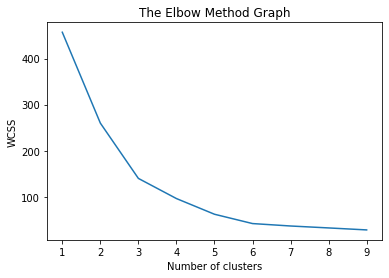

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:64: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


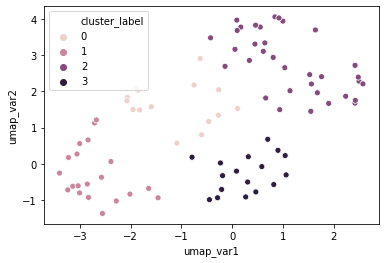

In [212]:
PDcluster_clust=elbow_clust(pdclust_umap[['SYDID','Date of assessment','umap_var1','umap_var2']],\
clustfit=4,dropvars=['SYDID','Date of assessment'])

sns.scatterplot(data=PDcluster_clust, x="umap_var1", y="umap_var2",hue='cluster_label')


In [213]:
mask1=(PDcombined['Date of assessment']==PDcombined['max_date'])

print(PDcombined.shape)
print(PDcluster_clust.shape)

varsused=['SYDID','Date of assessment','udprs_Disease_Progression','udprs_Age_Diagnosis','BDI_BDI Total','cog1_MMSE result',\
'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','DDE_norm']

mask=(pd.notnull(PDcluster_clust['SYDID'])&pd.notnull(PDcluster_clust['Date of assessment']))
mask2=(pd.notnull(PDcombined['SYDID'])&pd.notnull(PDcombined['Date of assessment']))


(252, 552)
(150, 5)


In [214]:
PDcluster_clust_new=PDcluster_clust[['SYDID','Date of assessment','cluster_label']][mask]
PDcombined_new=PDcombined[varsused][mask2&mask1]

In [215]:


PDcluster_clust_new['Date of assessment']=pd.to_datetime(PDcluster_clust_new['Date of assessment'])
PDcombined_new['Date of assessment']=pd.to_datetime(PDcombined_new['Date of assessment'])

print(PDcluster_clust_new.shape)
print(PDcombined_new.shape)

clust=pd.merge(PDcombined_new,PDcluster_clust_new,on=['SYDID','Date of assessment'],how='inner')
print(clust.shape)

(150, 3)
(151, 11)
(150, 12)


In [216]:


print(clust.shape)

clust_gp_mean=pd.DataFrame(clust.groupby(['cluster_label'])['udprs_Disease_Progression','udprs_Age_Diagnosis','cog1_MMSE result',\
 'udprs_non_tremor','udprs_tremor','udprs_tremor_ratio','cog1_NART','BDI_BDI Total'].mean()).reset_index()

clust_gp_size=pd.DataFrame(clust.groupby(['cluster_label']).size()).reset_index()
clust_gp_size.columns=['cluster_label','num_patients']

clust_gp_mean=pd.merge(clust_gp_mean,clust_gp_size,on='cluster_label',how='inner')
clust_gp_mean

(150, 12)


,cluster_label,udprs_Disease_Progression,udprs_Age_Diagnosis,cog1_MMSE result,udprs_non_tremor,udprs_tremor,udprs_tremor_ratio,cog1_NART,BDI_BDI Total,num_patients
0,0,0.145678,61.608886,28.569620,1.255696,0.521519,0.473668,110.187696,9.303797,79
1,1,0.023512,56.749213,28.800000,1.490000,0.480000,0.353672,105.391400,8.650000,20
2,2,0.023272,57.640295,28.529412,1.241176,0.547059,0.546882,110.529412,7.382353,34
3,3,0.031002,58.940774,28.470588,1.347059,0.600000,0.479288,113.352941,10.235294,17


In [191]:
PDcombined['Date of assessment']=pd.to_datetime(PDcombined['Date of assessment'])

PDCombined_clust=pd.merge(PDcombined,PDcluster_clust_new,on=['SYDID','Date of assessment'],how='inner')


In [194]:
PDCombined_clust.to_csv('%s%s' % (outdata,'PDCombined_clust.csv'))